# Muon spectra

Author: Hans Dembinski (https://github.com/HDembinski)

- prompt: mother has lifetime < D0

In [1]:
#basic imports and ipython setup
%load_ext autoreload
%matplotlib inline
%autoreload 2
import os
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams["font.size"] = 20
rcParams["figure.figsize"] = (7, 6)
from scipy.interpolate import interp1d
from scipy.integrate import trapz

import numpy as np
os.chdir('..')

#import solver related modules
from MCEq.core import MCEqRun
from mceq_config import config
#import primary model choices
import CRFluxModels as pm

In [2]:
interaction_models = (
    'DPMJet-III-2017.1',
    'DPMJet-III',
    'EPOS-LHC',
    'QGSJet-II-04',
    'QGSJet-II-03',
    'QGSJet-01',
    'SIBYLL-2.3c',
    'SIBYLL-2.1',
)

cr_energy = {"auger": 1e10, "icecube": 1e8}
h_obs = {"auger": 1425, "icecube": 2835}
theta_deg = {"auger": 67, "icecube": 13}    

lepton_spectra = {}
height_grid = {}

In [3]:
for experiment in ("auger", "icecube"):
    if experiment not in lepton_spectra:
        lepton_spectra[experiment] = {}
    for interaction_model in interaction_models:
        if interaction_model in lepton_spectra[experiment]:
            print "skipping", interaction_model
            continue
        lepton_spectra[experiment][interaction_model] = {}
        for prim in ("proton", "iron"):
            print "=== processing", experiment, interaction_model, prim, "==="
            spectra = lepton_spectra[experiment][interaction_model][prim] = {}

            cfg = dict(config)
            cfg["density_model"] = {
                "icecube": ("CORSIKA", ("BK_USStd", None)),#("MSIS00_IC", ("SouthPole", "January")),
                "auger": ("CORSIKA", ("BK_USStd", None)),
            }[experiment]
            cfg["h_obs"] = h_obs[experiment]
            mceq_run = MCEqRun(
                interaction_model,
                primary_model=(pm.HillasGaisser2012, 'H3a'),
                theta_deg=theta_deg[experiment],
                **cfg
            )

            a = {"proton": 1, "iron": 56}[prim]
            mceq_run.set_single_primary_particle(
                cr_energy[experiment],
                {"proton": 14, "iron": 5626}[prim]
            )

            Xvec = np.arange(1, mceq_run.density_model.max_X, 5)
            if experiment not in height_grid:
                height_grid[experiment] = (Xvec, mceq_run.density_model.s_lX2h(np.log(Xvec))/1e2)

            mceq_run.solve(int_grid=Xvec, grid_var="X")

            # muons
            spectra["egrid"] = mceq_run.e_grid
            for t in ("total", "conv", "pr"):
                spectra["mu_" + t] = (
                    mceq_run.get_solution(t + '_mu+', 0) +
                    mceq_run.get_solution(t + '_mu-', 0)
                )

            mu_long = np.empty_like(Xvec)
            for idx, X in enumerate(Xvec):
                y = (mceq_run.get_solution("total_mu+", 0, grid_idx=idx) +
                     mceq_run.get_solution("total_mu-", 0, grid_idx=idx))
                mu_long[idx] = trapz(y, mceq_run.e_grid)
            spectra["mu_long"] = mu_long

            if experiment == "icecube":
                for n in ("numu", "nue", "nutau"):
                    for t in ("total", "conv", "pr"):
                        # since there are no conventional tau neutrinos, prompt=total
                        if n == "nutau" and t != "total": continue
                        spectra[n + "_" + t] = (
                            mceq_run.get_solution(t + '_' + n, 0) +
                            mceq_run.get_solution(t + '_anti' + n, 0)
                        )

=== processing auger DPMJet-III-2017.1 proton ===
InteractionYields::_load(): entering..
InteractionYields::_load(): Looking for C:\Users\afedy\Source\Repos\MCEq\data\DPMJETIII20171_yields_compact.bz2
DecayYields:_load():: Loading file C:\Users\afedy\Source\Repos\MCEq\data\decays_v1_compact.ppd
DecayYields::_load(): Warning: no decay distributions for 16 found.
DecayYields::_load(): Warning: no decay distributions for -16 found.
MCEqRun::_gen_list_of_particles():Generating particle list.
MCEqRun::_init_alias_tables():Initializing links to alias IDs.

Hadrons and stable particles:

"gamma", "p", "p-bar", "n-bar", "n"

Mixed:

"pi-", "pi+", "K0L", "K-", "K+", "Lambda0", "Lambda0-bar", "K0S", 
"D+", "D-", "Ds+", "Ds-", "D0", "D0-bar"

Resonances:



Leptons:

"e-", "nue", "numu", "nutau", "antinutau", "antinumu", "antinue", "e+", 
"mu-", "mu+"

Aliases:
"obs_numu", "obs_nutau", "pr_antinutau", "pr_antinumu", "pr_antinue", "obs_antinue", "k_nue", "k_numu", 
"k_nutau", "pi_antinutau", "pi_a

Performance:   0.73ms/iteration

MCEqRun::_forward_euler(): time elapsed during integration: 0.901000022888 sec
=== processing auger DPMJet-III iron ===
InteractionYields::_load(): entering..
InteractionYields::_load(): Looking for C:\Users\afedy\Source\Repos\MCEq\data\DPMJETIII_yields_compact.bz2
DecayYields:_load():: Loading file C:\Users\afedy\Source\Repos\MCEq\data\decays_v1_compact.ppd
DecayYields::_load(): Warning: no decay distributions for 16 found.
DecayYields::_load(): Warning: no decay distributions for -16 found.
MCEqRun::_gen_list_of_particles():Generating particle list.
MCEqRun::_init_alias_tables():Initializing links to alias IDs.

Hadrons and stable particles:

"gamma", "p", "p-bar", "n-bar", "n"

Mixed:

"pi-", "pi+", "K0L", "K-", "K+", "Lambda0", "Lambda0-bar", "K0S", 
"D+", "D-", "Ds+", "Ds-", "D0", "D0-bar"

Resonances:



Leptons:

"e-", "nue", "numu", "nutau", "antinutau", "antinumu", "antinue", "e+", 
"mu-", "mu+"

Aliases:
"obs_numu", "obs_nutau", "pr_antinutau"

Performance:   0.50ms/iteration

MCEqRun::_forward_euler(): time elapsed during integration: 0.593999862671 sec
=== processing auger QGSJet-II-04 proton ===
InteractionYields::_load(): entering..
InteractionYields::_load(): Looking for C:\Users\afedy\Source\Repos\MCEq\data\QGSJETII04_yields_compact_ledpm.bz2
DecayYields:_load():: Loading file C:\Users\afedy\Source\Repos\MCEq\data\decays_v1_compact.ppd
MCEqRun::_gen_list_of_particles():Generating particle list.
MCEqRun::_init_alias_tables():Initializing links to alias IDs.

Hadrons and stable particles:

"gamma", "p", "p-bar", "n", "n-bar"

Mixed:

"pi-", "pi+", "K0L", "K-", "K+", "Lambda0", "Lambda0-bar", "K0S"

Resonances:



Leptons:

"e-", "nue", "numu", "nutau", "antinutau", "antinumu", "antinue", "e+", 
"mu-", "mu+"

Aliases:
"obs_numu", "obs_nutau", "pr_antinutau", "pr_antinumu", "pr_antinue", "obs_antinue", "k_nue", "k_numu", 
"k_nutau", "pi_antinutau", "pi_antinue", "pi_antinumu", "pi_nue", "pi_numu", "pi_nutau", "k_antinutau",

Performance:   0.46ms/iteration

MCEqRun::_forward_euler(): time elapsed during integration: 0.540000200272 sec
=== processing auger QGSJet-II-03 iron ===
InteractionYields::_load(): entering..
InteractionYields::_load(): Looking for C:\Users\afedy\Source\Repos\MCEq\data\QGSJETII03_yields_compact_ledpm.bz2
DecayYields:_load():: Loading file C:\Users\afedy\Source\Repos\MCEq\data\decays_v1_compact.ppd
MCEqRun::_gen_list_of_particles():Generating particle list.
MCEqRun::_init_alias_tables():Initializing links to alias IDs.

Hadrons and stable particles:

"gamma", "p", "p-bar", "n", "n-bar"

Mixed:

"pi-", "pi+", "K0L", "K-", "K+", "Lambda0", "Lambda0-bar", "K0S"

Resonances:



Leptons:

"e-", "nue", "numu", "nutau", "antinutau", "antinumu", "antinue", "e+", 
"mu-", "mu+"

Aliases:
"obs_numu", "obs_nutau", "pr_antinutau", "pr_antinumu", "pr_antinue", "obs_antinue", "k_nue", "k_numu", 
"k_nutau", "pi_antinutau", "pi_antinue", "pi_antinumu", "pi_nue", "pi_numu", "pi_nutau", "k_antinutau", 


Performance:   0.56ms/iteration

MCEqRun::_forward_euler(): time elapsed during integration: 0.694999933243 sec
=== processing auger SIBYLL-2.3c proton ===
InteractionYields::_load(): entering..
InteractionYields::_load(): Looking for C:\Users\afedy\Source\Repos\MCEq\data\SIBYLL23C_yields_compact_ledpm.bz2
DecayYields:_load():: Loading file C:\Users\afedy\Source\Repos\MCEq\data\decays_v1_compact.ppd
MCEqRun::_gen_list_of_particles():Generating particle list.
MCEqRun::_init_alias_tables():Initializing links to alias IDs.

Hadrons and stable particles:

"gamma", "p", "p-bar", "n-bar", "n"

Mixed:

"pi-", "pi+", "K0L", "K-", "K+", "Lambda0", "Lambda0-bar", "K0S", 
"D+", "D-", "Ds+", "Ds-", "D0", "D0-bar"

Resonances:



Leptons:

"e-", "nue", "numu", "nutau", "antinutau", "antinumu", "antinue", "e+", 
"mu-", "mu+"

Aliases:
"obs_numu", "obs_nutau", "pr_antinutau", "pr_antinumu", "pr_antinue", "obs_antinue", "k_nue", "k_numu", 
"k_nutau", "pi_antinutau", "pi_antinue", "pi_antinumu", "pi_nu

Performance:   0.59ms/iteration

MCEqRun::_forward_euler(): time elapsed during integration: 0.700999975204 sec
=== processing auger SIBYLL-2.1 iron ===
InteractionYields::_load(): entering..
InteractionYields::_load(): Looking for C:\Users\afedy\Source\Repos\MCEq\data\SIBYLL21_yields_compact_ledpm.bz2
DecayYields:_load():: Loading file C:\Users\afedy\Source\Repos\MCEq\data\decays_v1_compact.ppd
MCEqRun::_gen_list_of_particles():Generating particle list.
MCEqRun::_init_alias_tables():Initializing links to alias IDs.

Hadrons and stable particles:

"gamma", "p", "p-bar", "n", "n-bar"

Mixed:

"pi-", "pi+", "K0L", "K-", "K+", "Lambda0", "Lambda0-bar", "K0S"

Resonances:



Leptons:

"e-", "nue", "numu", "nutau", "antinutau", "antinumu", "antinue", "e+", 
"mu-", "mu+"

Aliases:
"obs_numu", "obs_nutau", "pr_antinutau", "pr_antinumu", "pr_antinue", "obs_antinue", "k_nue", "k_numu", 
"k_nutau", "pi_antinutau", "pi_antinue", "pi_antinumu", "pi_nue", "pi_numu", "pi_nutau", "k_antinutau", 
"k_a

Performance:   0.76ms/iteration

MCEqRun::_forward_euler(): time elapsed during integration: 0.392999887466 sec
=== processing icecube DPMJet-III proton ===
InteractionYields::_load(): entering..
InteractionYields::_load(): Looking for C:\Users\afedy\Source\Repos\MCEq\data\DPMJETIII_yields_compact.bz2
DecayYields:_load():: Loading file C:\Users\afedy\Source\Repos\MCEq\data\decays_v1_compact.ppd
DecayYields::_load(): Warning: no decay distributions for 16 found.
DecayYields::_load(): Warning: no decay distributions for -16 found.
MCEqRun::_gen_list_of_particles():Generating particle list.
MCEqRun::_init_alias_tables():Initializing links to alias IDs.

Hadrons and stable particles:

"gamma", "p", "p-bar", "n-bar", "n"

Mixed:

"pi-", "pi+", "K0L", "K-", "K+", "Lambda0", "Lambda0-bar", "K0S", 
"D+", "D-", "Ds+", "Ds-", "D0", "D0-bar"

Resonances:



Leptons:

"e-", "nue", "numu", "nutau", "antinutau", "antinumu", "antinue", "e+", 
"mu-", "mu+"

Aliases:
"obs_numu", "obs_nutau", "pr_antinu

Performance:   0.54ms/iteration

MCEqRun::_forward_euler(): time elapsed during integration: 0.269000053406 sec
=== processing icecube EPOS-LHC iron ===
InteractionYields::_load(): entering..
InteractionYields::_load(): Looking for C:\Users\afedy\Source\Repos\MCEq\data\EPOSLHC_yields_compact_ledpm.bz2
DecayYields:_load():: Loading file C:\Users\afedy\Source\Repos\MCEq\data\decays_v1_compact.ppd
MCEqRun::_gen_list_of_particles():Generating particle list.
MCEqRun::_init_alias_tables():Initializing links to alias IDs.

Hadrons and stable particles:

"gamma", "p", "p-bar", "n", "n-bar"

Mixed:

"pi-", "pi+", "K0L", "K-", "K+", "Lambda0", "Lambda0-bar", "K0S"

Resonances:



Leptons:

"e-", "nue", "numu", "nutau", "antinutau", "antinumu", "antinue", "e+", 
"mu-", "mu+"

Aliases:
"obs_numu", "obs_nutau", "pr_antinutau", "pr_antinumu", "pr_antinue", "obs_antinue", "k_nue", "k_numu", 
"k_nutau", "pi_antinutau", "pi_antinue", "pi_antinumu", "pi_nue", "pi_numu", "pi_nutau", "k_antinutau", 
"k_an

Performance:   0.48ms/iteration

MCEqRun::_forward_euler(): time elapsed during integration: 0.238000154495 sec
=== processing icecube QGSJet-II-03 proton ===
InteractionYields::_load(): entering..
InteractionYields::_load(): Looking for C:\Users\afedy\Source\Repos\MCEq\data\QGSJETII03_yields_compact_ledpm.bz2
DecayYields:_load():: Loading file C:\Users\afedy\Source\Repos\MCEq\data\decays_v1_compact.ppd
MCEqRun::_gen_list_of_particles():Generating particle list.
MCEqRun::_init_alias_tables():Initializing links to alias IDs.

Hadrons and stable particles:

"gamma", "p", "p-bar", "n", "n-bar"

Mixed:

"pi-", "pi+", "K0L", "K-", "K+", "Lambda0", "Lambda0-bar", "K0S"

Resonances:



Leptons:

"e-", "nue", "numu", "nutau", "antinutau", "antinumu", "antinue", "e+", 
"mu-", "mu+"

Aliases:
"obs_numu", "obs_nutau", "pr_antinutau", "pr_antinumu", "pr_antinue", "obs_antinue", "k_nue", "k_numu", 
"k_nutau", "pi_antinutau", "pi_antinue", "pi_antinumu", "pi_nue", "pi_numu", "pi_nutau", "k_antinutau

Performance:   0.57ms/iteration

MCEqRun::_forward_euler(): time elapsed during integration: 0.293999910355 sec
=== processing icecube QGSJet-01 iron ===
InteractionYields::_load(): entering..
InteractionYields::_load(): Looking for C:\Users\afedy\Source\Repos\MCEq\data\QGSJET01_yields_compact_ledpm.bz2
DecayYields:_load():: Loading file C:\Users\afedy\Source\Repos\MCEq\data\decays_v1_compact.ppd
MCEqRun::_gen_list_of_particles():Generating particle list.
MCEqRun::_init_alias_tables():Initializing links to alias IDs.

Hadrons and stable particles:

"gamma", "p", "p-bar", "n-bar", "n"

Mixed:

"pi-", "pi+", "K0L", "K-", "K+", "Lambda0", "Lambda0-bar", "K0S", 
"D+", "D-", "D0", "D0-bar"

Resonances:



Leptons:

"e-", "nue", "numu", "nutau", "antinutau", "antinumu", "antinue", "e+", 
"mu-", "mu+"

Aliases:
"obs_numu", "obs_nutau", "pr_antinutau", "pr_antinumu", "pr_antinue", "obs_antinue", "k_nue", "k_numu", 
"k_nutau", "pi_antinutau", "pi_antinue", "pi_antinumu", "pi_nue", "pi_numu", "p

Performance:   0.69ms/iteration

MCEqRun::_forward_euler(): time elapsed during integration: 0.358000040054 sec
=== processing icecube SIBYLL-2.1 proton ===
InteractionYields::_load(): entering..
InteractionYields::_load(): Looking for C:\Users\afedy\Source\Repos\MCEq\data\SIBYLL21_yields_compact_ledpm.bz2
DecayYields:_load():: Loading file C:\Users\afedy\Source\Repos\MCEq\data\decays_v1_compact.ppd
MCEqRun::_gen_list_of_particles():Generating particle list.
MCEqRun::_init_alias_tables():Initializing links to alias IDs.

Hadrons and stable particles:

"gamma", "p", "p-bar", "n", "n-bar"

Mixed:

"pi-", "pi+", "K0L", "K-", "K+", "Lambda0", "Lambda0-bar", "K0S"

Resonances:



Leptons:

"e-", "nue", "numu", "nutau", "antinutau", "antinumu", "antinue", "e+", 
"mu-", "mu+"

Aliases:
"obs_numu", "obs_nutau", "pr_antinutau", "pr_antinumu", "pr_antinue", "obs_antinue", "k_nue", "k_numu", 
"k_nutau", "pi_antinutau", "pi_antinue", "pi_antinumu", "pi_nue", "pi_numu", "pi_nutau", "k_antinutau", 


# Plot with matplotlib

In [5]:
def model_color(name):
    model_colors = {"EPOS-LHC": "k",
                    "SIBYLL" : "b",
                    "DPMJet" : "g",
                    "QGSJet" : "r",
                    "QGSJet-01": "0.5"}
    for k,v in model_colors.items():
        if name.startswith(k):
            return v

def model_linestyle(name):
    if name in ("EPOS-LHC", "SIBYLL-2.3.5", "DPMJet-III-2017.1", "QGSJet-II-04"):
        return "-"
    else:
        return ":"


auger 2209 gcm-2
icecube 749 gcm-2


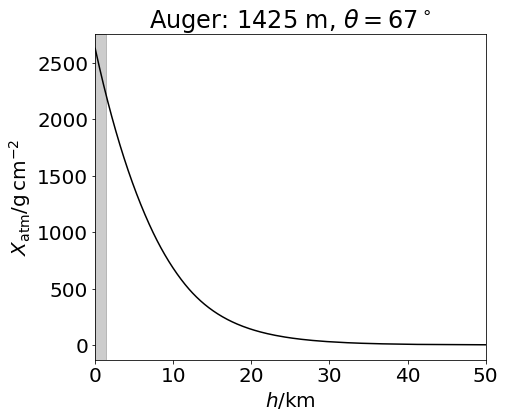

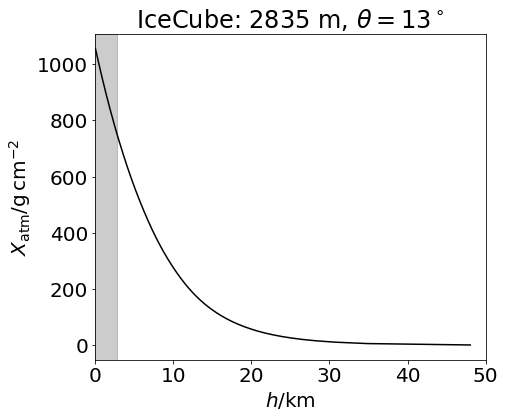

In [6]:
# atmoshpere
for experiment, (X, h) in height_grid.items():
    plt.figure()
    plt.title({
        "auger": r"Auger: 1425 m, $\theta = 67^\circ$",
        "icecube": r"IceCube: 2835 m, $\theta = 13^\circ$",
    }[experiment])
    plt.plot(h/1e3, X, "k-")
    plt.axvspan(0, h_obs[experiment]/1e3, color="k", alpha=0.2)
    x_ground = interp1d(h, X)(h_obs[experiment])
    print "%s %.0f gcm-2" % (experiment, x_ground)
    plt.xlim(0, 50)
    plt.xlabel("$h$/km")
    plt.ylabel("$X_\mathrm{atm}/\mathrm{g\,cm^{-2}}$")
    #plt.semilogy()


auger iron h_mu_max 8.9 km
auger proton h_mu_max 8.3 km
ratio 1.61719299803
auger iron h_mu_max 8.8 km
auger proton h_mu_max 8.3 km
ratio 1.67822541873
auger iron h_mu_max 7.9 km
auger proton h_mu_max 7.4 km
ratio 1.4849040102
auger iron h_mu_max 8.0 km
auger proton h_mu_max 7.5 km
ratio 1.51975408908
auger iron h_mu_max 8.0 km
auger proton h_mu_max 7.6 km
ratio 1.48733513725
auger iron h_mu_max 8.4 km
auger proton h_mu_max 7.9 km
ratio 1.46300132335
auger iron h_mu_max 8.0 km
auger proton h_mu_max 7.5 km
ratio 1.54047169614
auger iron h_mu_max 8.5 km
auger proton h_mu_max 8.0 km
ratio 1.74809784834
icecube iron h_mu_max 2.9 km
icecube proton h_mu_max 2.0 km
ratio 1.61657609856
icecube iron h_mu_max 2.9 km
icecube proton h_mu_max 1.9 km
ratio 1.68623130302
icecube iron h_mu_max 1.9 km
icecube proton h_mu_max 0.9 km
ratio 1.51838942846
icecube iron h_mu_max 1.9 km
icecube proton h_mu_max 0.9 km
ratio 1.58698573626
icecube iron h_mu_max 1.9 km
icecube proton h_mu_max 1.0 km
ratio 1.61473

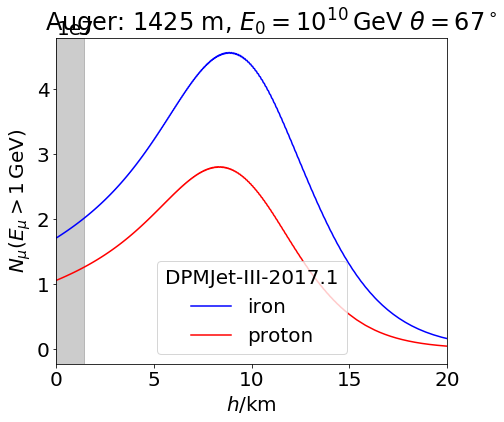

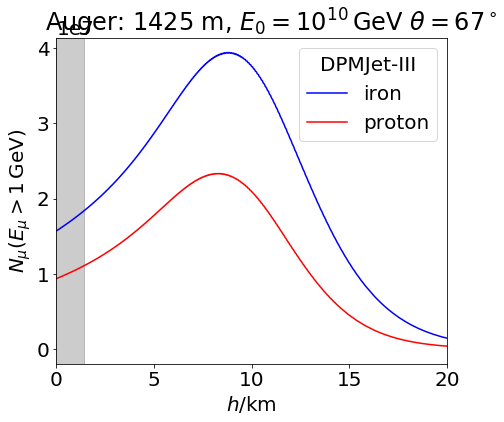

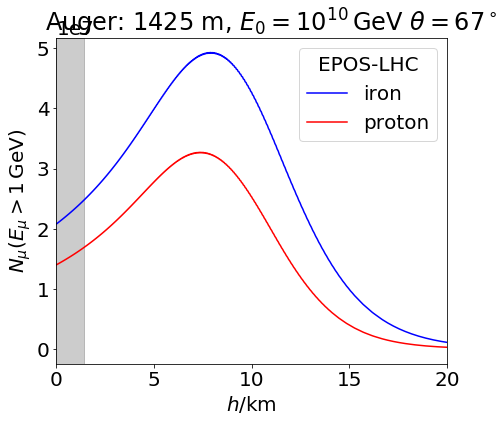

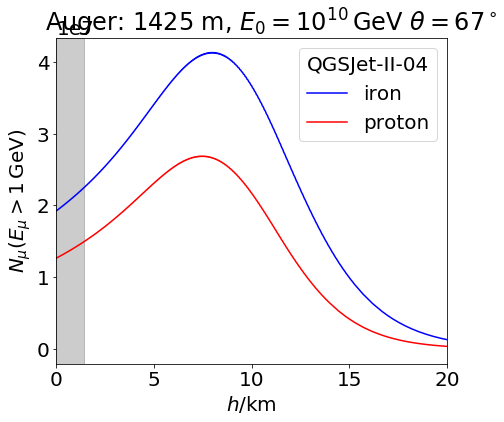

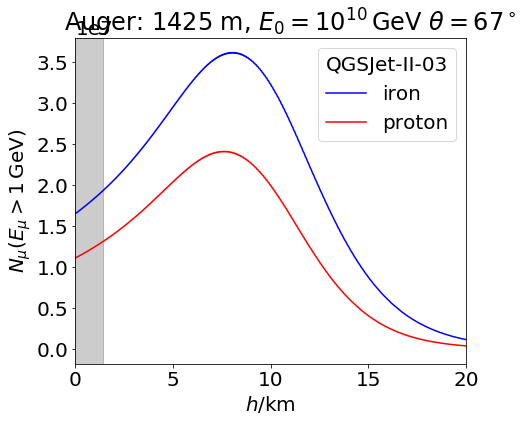

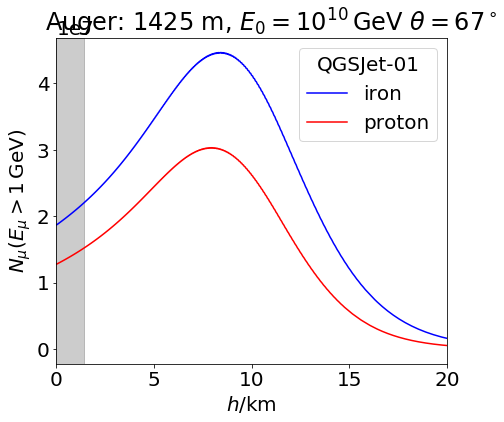

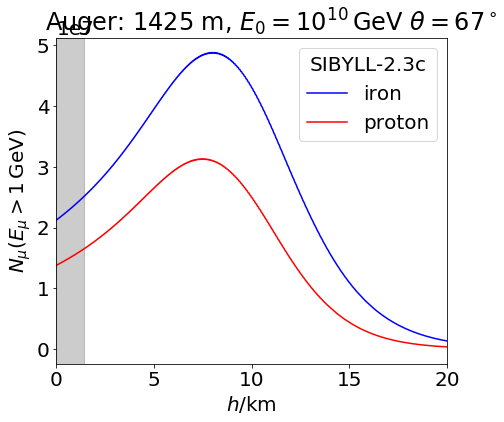

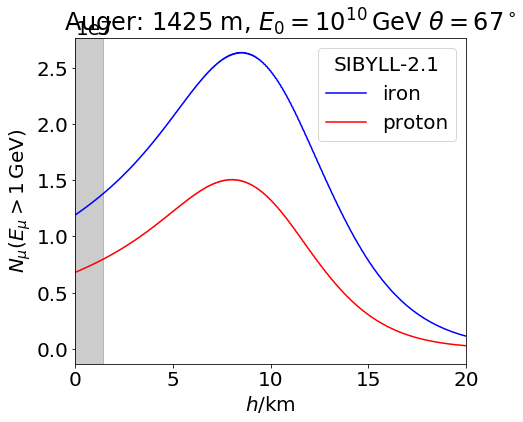

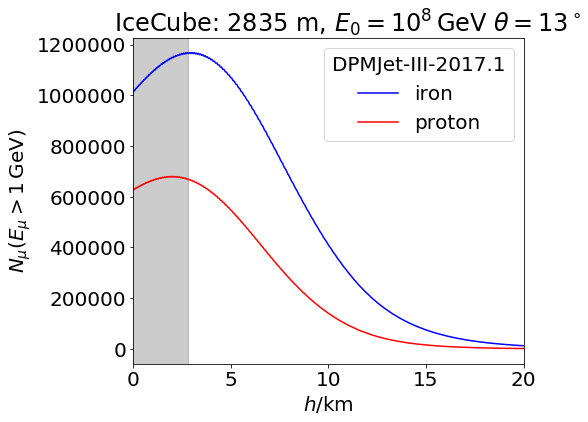

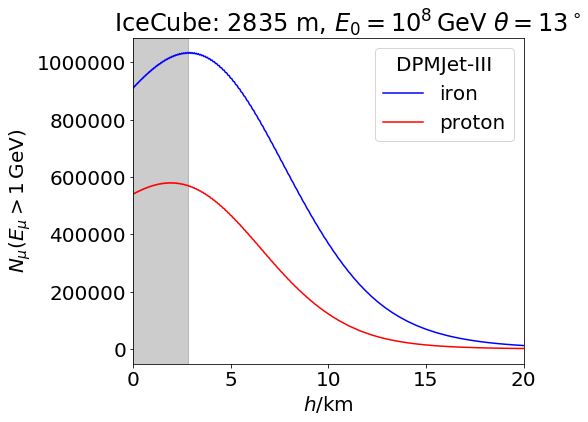

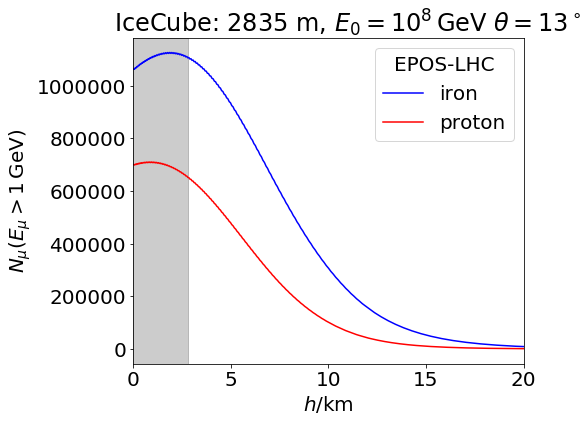

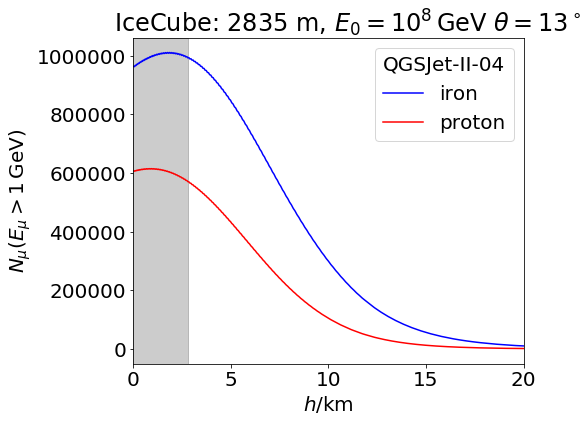

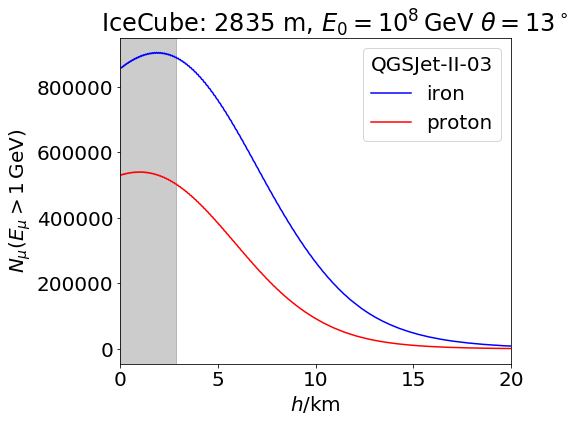

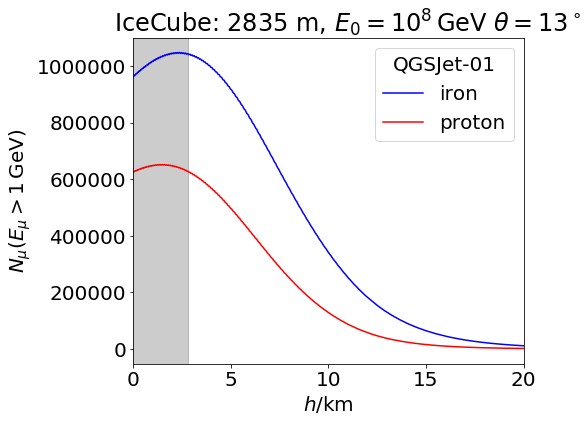

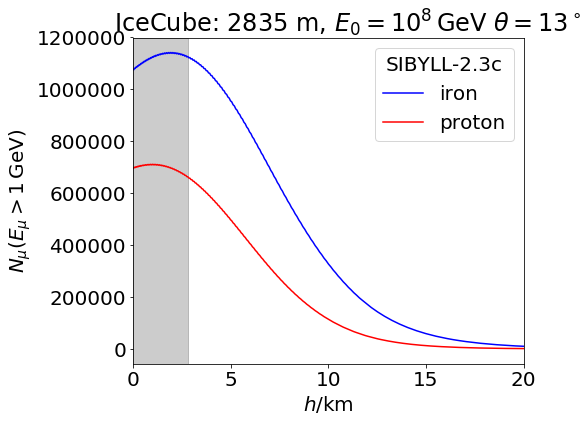

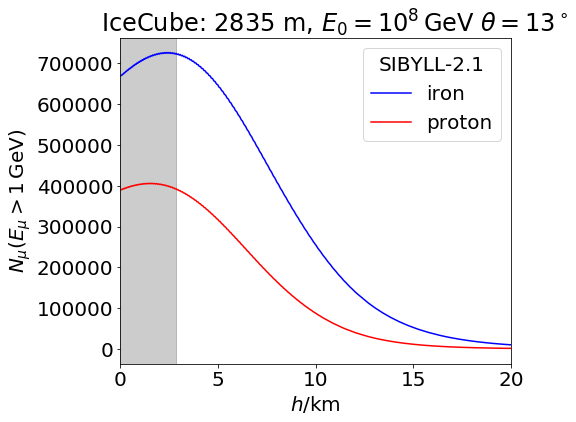

In [7]:
# longitudinal
h_mu_max = {"auger": 0.0, "icecube": 0.0}

for experiment in lepton_spectra:
    X, h = height_grid[experiment]
    for interaction_model in interaction_models:
        if interaction_model not in lepton_spectra[experiment]:
            continue
        prim_spectra = lepton_spectra[experiment][interaction_model]

        plt.figure()
        plt.title({
            "auger": r"Auger: 1425 m, $E_0 = 10^{10}\,$GeV $\theta = 67^\circ$",
            "icecube": r"IceCube: 2835 m, $E_0 = 10^8\,$GeV $\theta = 13^\circ$",
        }[experiment], x=0.55)
        for prim, spectra in prim_spectra.items():
            y = spectra["mu_long"]
            color = {"proton" : "r", "iron": "b"}[prim]
            label = {"proton" : "p", "iron": "Fe"}[prim] 
            plt.plot(h/1e3, y, "k-", color=color, label=prim)
            hm = h[np.argmax(y)]
            h_mu_max[experiment] += hm
            print "%s %s h_mu_max %.1f km" % (experiment, prim, hm/1e3)
        print "ratio", prim_spectra["iron"]["mu_long"][-1]/prim_spectra["proton"]["mu_long"][-1]
        plt.xlim(0, 20)
        plt.legend(title=interaction_model)
        plt.axvspan(0, h_obs[experiment]/1e3, color="k", alpha=0.2)
        plt.xlabel("$h$/km")
        plt.ylabel("$N_\mu(E_\mu > 1\,\mathrm{GeV})$")

for k, v in h_mu_max.items():
    h_mu_max[k] = v/2
    print "%s avg h_mu_max %.1f km" % (experiment, v/2e3)

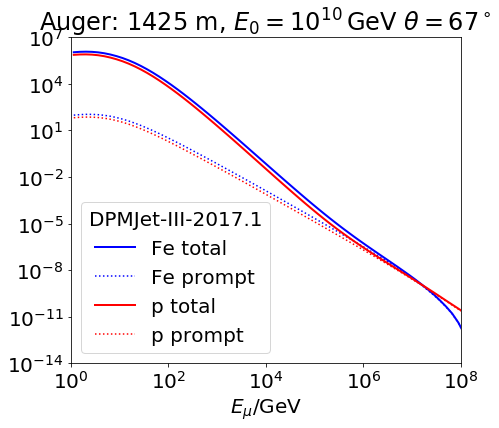

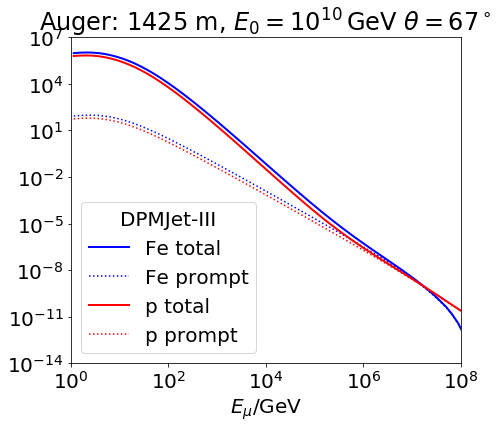

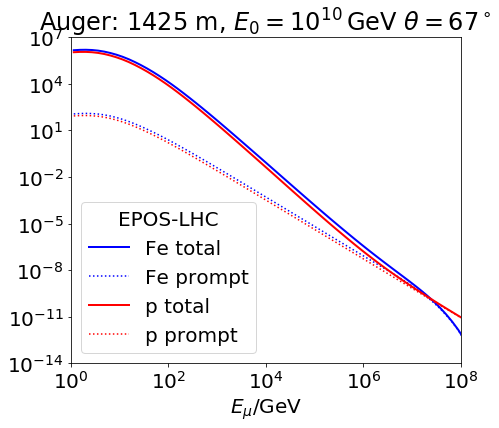

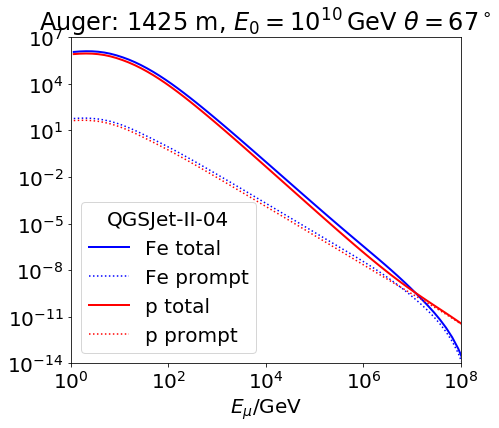

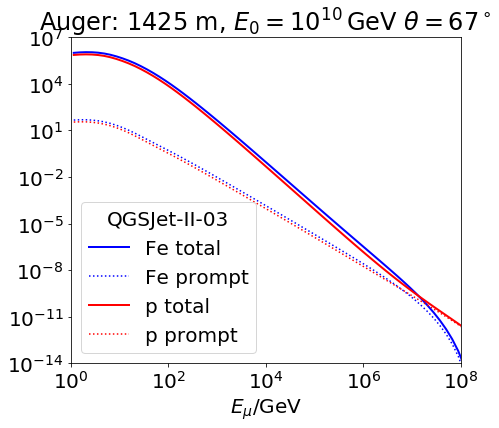

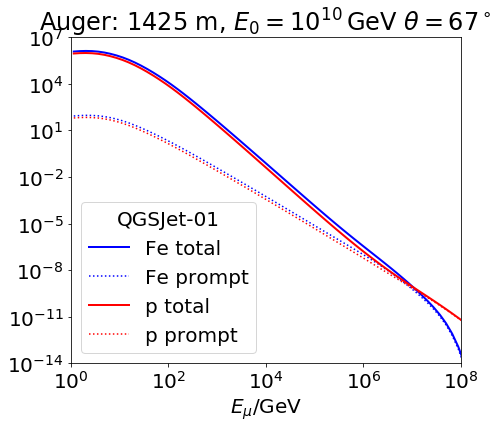

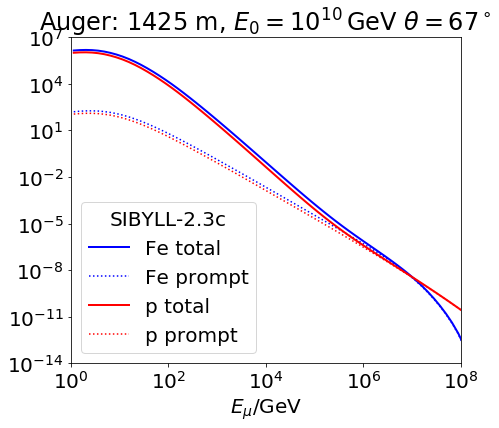

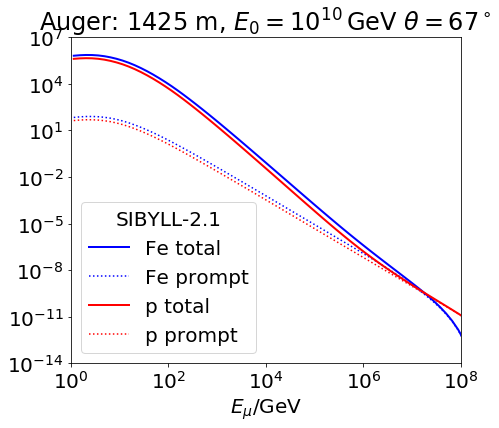

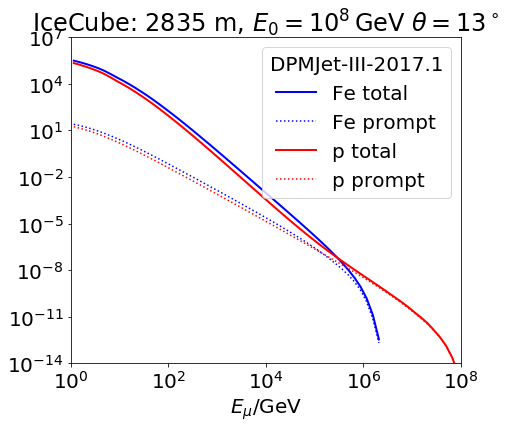

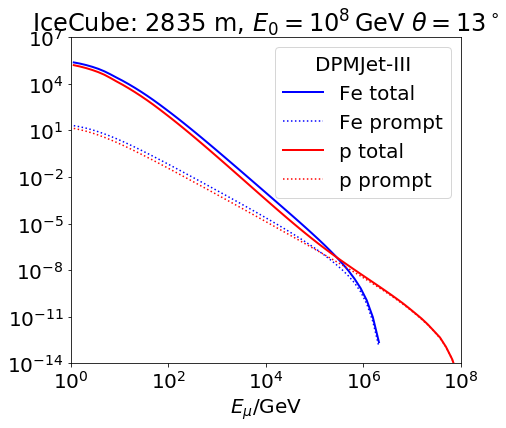

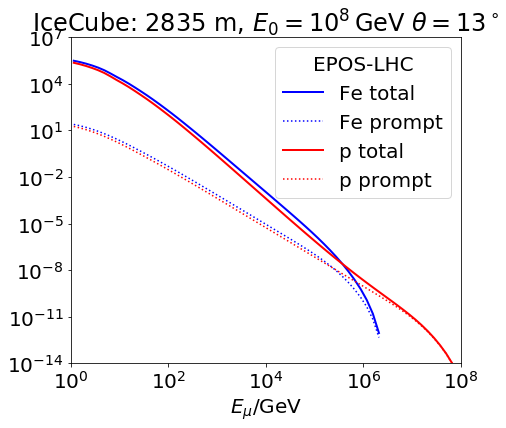

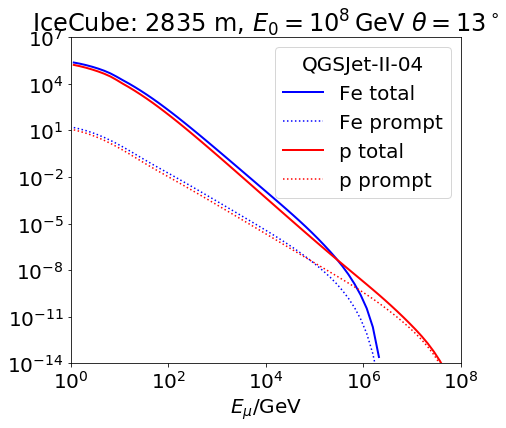

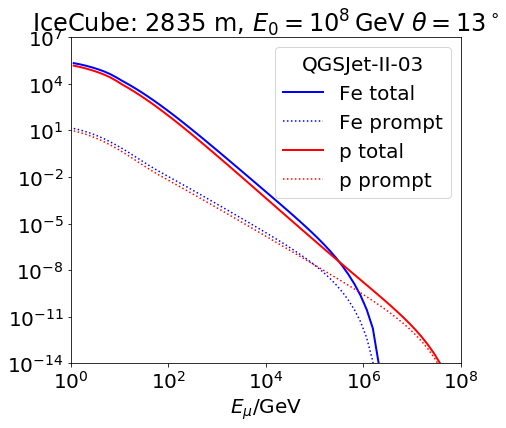

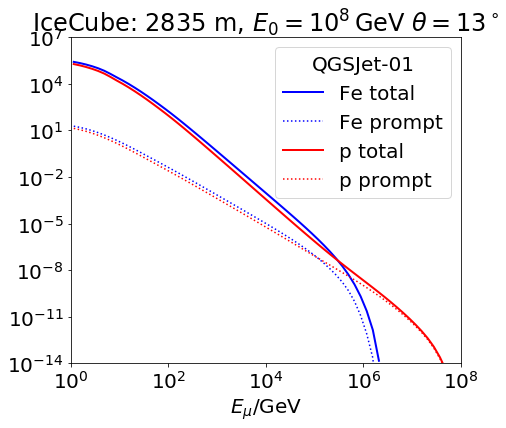

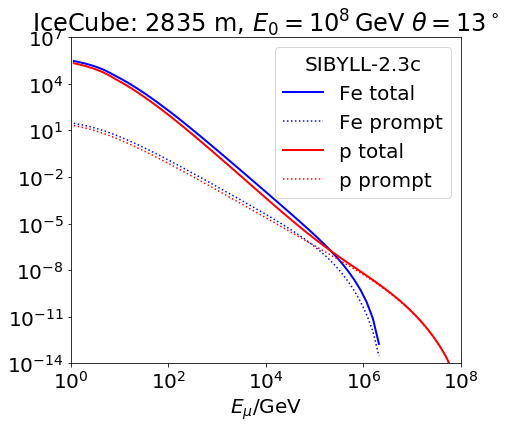

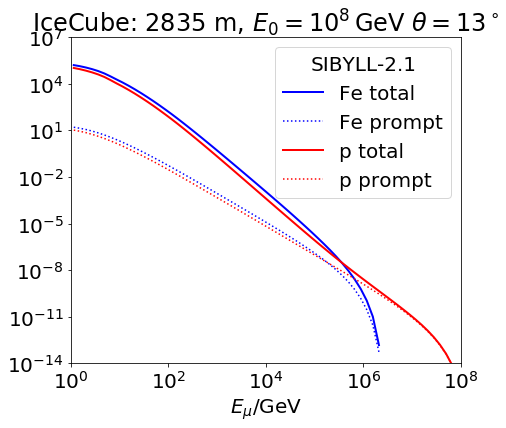

In [8]:
# muon spectra 1
for experiment in lepton_spectra:
    for interaction_model in interaction_models:
        if interaction_model not in lepton_spectra[experiment]:
            continue
        prim_spectra = lepton_spectra[experiment][interaction_model]

        plt.figure()
        plt.title({
            "auger": r"Auger: 1425 m, $E_0 = 10^{10}\,$GeV $\theta = 67^\circ$",
            "icecube": r"IceCube: 2835 m, $E_0 = 10^8\,$GeV $\theta = 13^\circ$",
        }[experiment])
        for prim, spectra in prim_spectra.items():
            x = spectra["egrid"]
            y1 = spectra["mu_total"]
            y2 = spectra["mu_pr"]
            color = {"proton" : "r", "iron": "b"}[prim]
            label = {"proton" : "p", "iron": "Fe"}[prim] 
            plt.plot(x, y1, "k-", color=color, lw=2, label=label + " total")
            plt.plot(x, y2, "k:", color=color, label=label + " prompt")
        plt.loglog()
        plt.xlim(1, 1e8)
        plt.ylim(1e-14, 1e7)
        plt.xlabel(r"$E_\mu$/GeV")
        plt.legend(title=interaction_model)


C:\Users\afedy\Anaconda2\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in divide


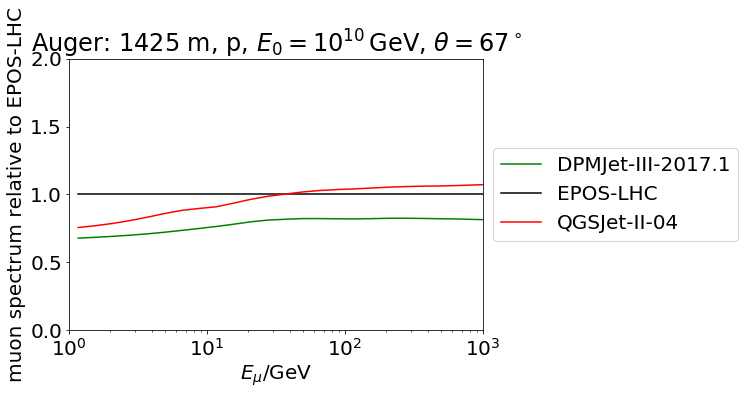

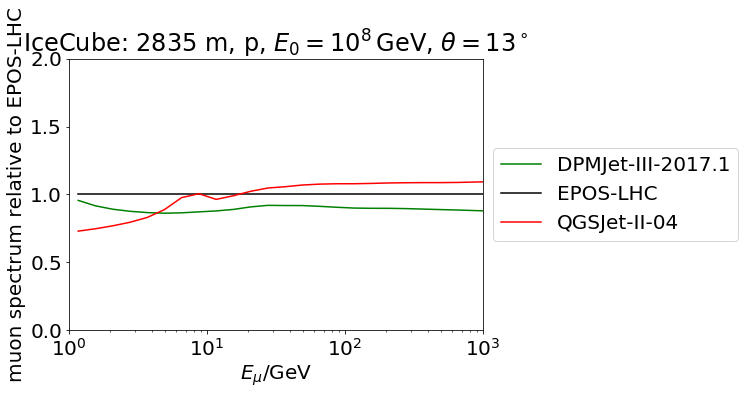

In [9]:
# muon spectra 2
from collections import OrderedDict
for experiment in lepton_spectra:        
    plt.figure(figsize=(10, 5))
    plt.title({
        "auger": r"Auger: 1425 m, p, $E_0 = 10^{10}\,$GeV, $\theta = 67^\circ$",
        "icecube": r"IceCube: 2835 m, p, $E_0 = 10^8\,$GeV, $\theta = 13^\circ$",
    }[experiment], x=0.5)

    y = OrderedDict()
    for interaction_model in interaction_models:
        if interaction_model not in lepton_spectra[experiment]:
            continue
        if model_linestyle(interaction_model) != "-":
            continue
        prim_spectra = lepton_spectra[experiment][interaction_model]
        spectra = prim_spectra["proton"]
        y[interaction_model] = spectra["mu_total"]
        x = spectra["egrid"]

    for interaction_model, yi in y.items():
        plt.plot(x, yi / y["EPOS-LHC"], "-",
                 color=model_color(interaction_model), label=interaction_model)
    plt.semilogx()
    plt.ylim(0., 2)
    plt.xlim(1, 1e3)
    plt.xlabel(r"$E_\mu$/GeV")
    plt.ylabel("muon spectrum relative to EPOS-LHC")
    plt.subplots_adjust(right=0.7)
    plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))


C:\Users\afedy\Anaconda2\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in divide
  from ipykernel import kernelapp as app
C:\Users\afedy\Anaconda2\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
C:\Users\afedy\Anaconda2\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in divide


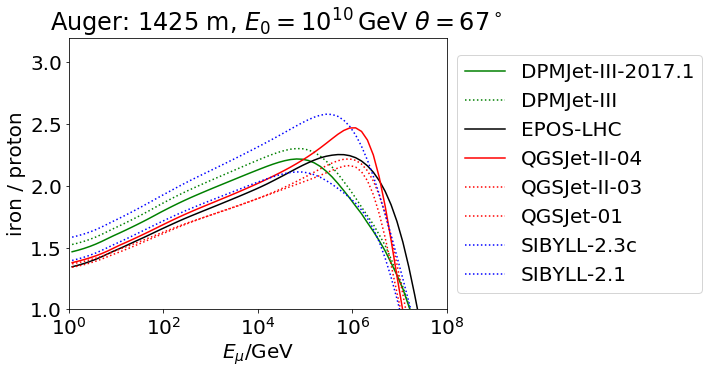

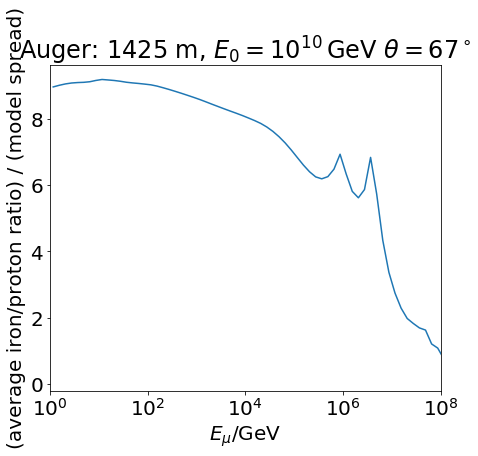

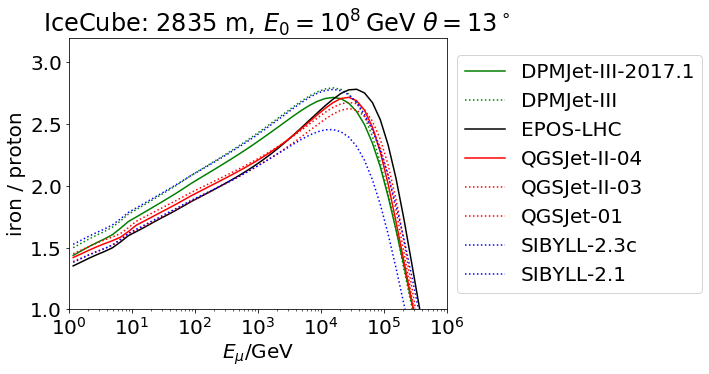

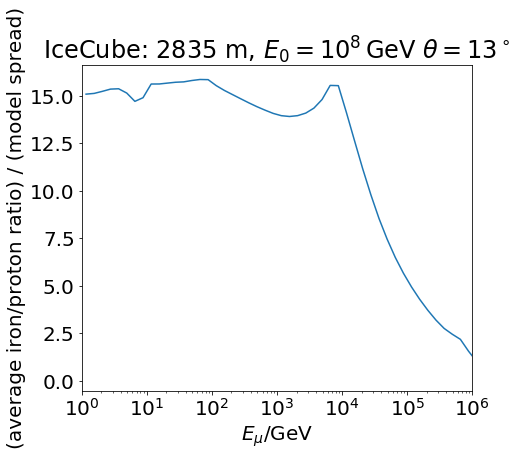

In [10]:
# muon spectra ratios
for experiment in lepton_spectra:
    ratios = []

    plt.figure(figsize=(10, 5))
    plt.title({
        "auger": r"Auger: 1425 m, $E_0 = 10^{10}\,$GeV $\theta = 67^\circ$",
        "icecube": r"IceCube: 2835 m, $E_0 = 10^8\,$GeV $\theta = 13^\circ$",
    }[experiment], x=0.55)

    for interaction_model in interaction_models:
        if interaction_model not in lepton_spectra[experiment]:
            continue
        prim_spectra = lepton_spectra[experiment][interaction_model]
        ratio = prim_spectra["iron"]["mu_total"] / prim_spectra["proton"]["mu_total"]
        xiron = prim_spectra["iron"]["egrid"]
        xproton = prim_spectra["proton"]["egrid"]
        assert(np.all(xiron == xproton))
        
        ratios.append(ratio)
        plt.plot(x, ratio,
                 color=model_color(interaction_model),
                 ls=model_linestyle(interaction_model),
                 label=interaction_model)
        plt.semilogx()
        plt.xlim(1, cr_energy[experiment]/1e2)
        plt.ylim(1, 3.2)
        plt.xlabel(r"$E_\mu$/GeV")
        plt.ylabel(r"iron / proton")
    plt.subplots_adjust(right=0.65)
    plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))

    plt.figure()
    plt.title({
        "auger": r"Auger: 1425 m, $E_0 = 10^{10}\,$GeV $\theta = 67^\circ$",
        "icecube": r"IceCube: 2835 m, $E_0 = 10^8\,$GeV $\theta = 13^\circ$",
    }[experiment])

    m = np.mean(ratios, axis=0)
    d = np.zeros_like(m)
    for r in ratios:
        a = np.abs(r-m)
        d[d<a] = a[d<a]
    s = np.var(ratios, axis=0) ** 0.5
    plt.plot(xproton, m/d)
    plt.semilogx()
    plt.xlim(1, cr_energy[experiment]/1e2)
    plt.xlabel(r"$E_\mu$/GeV")
    plt.ylabel(r"(average iron/proton ratio) / (model spread)")


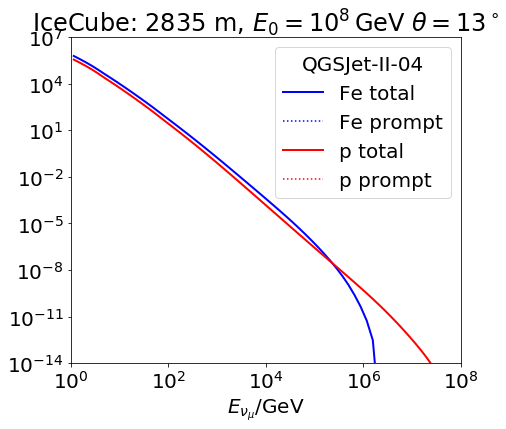

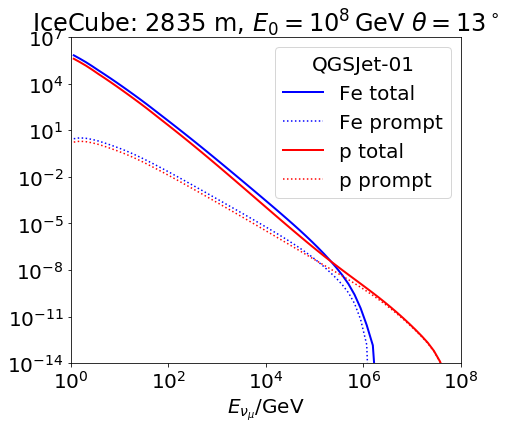

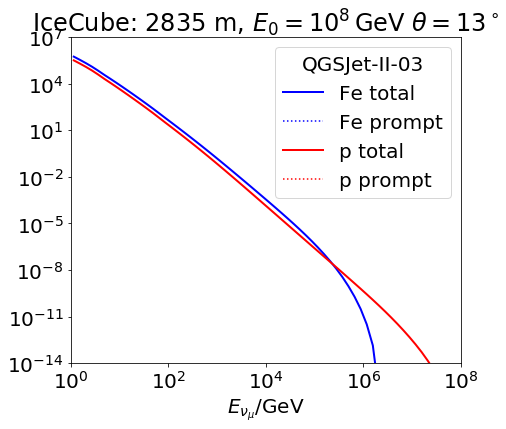

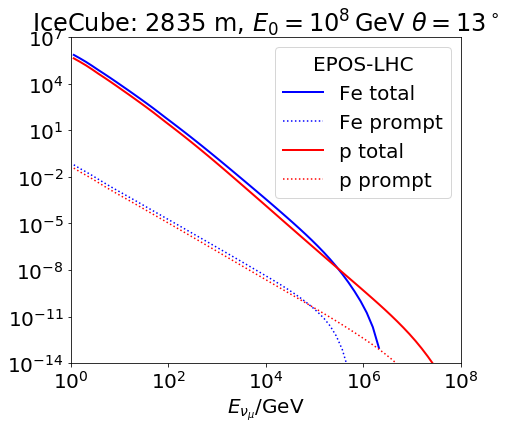

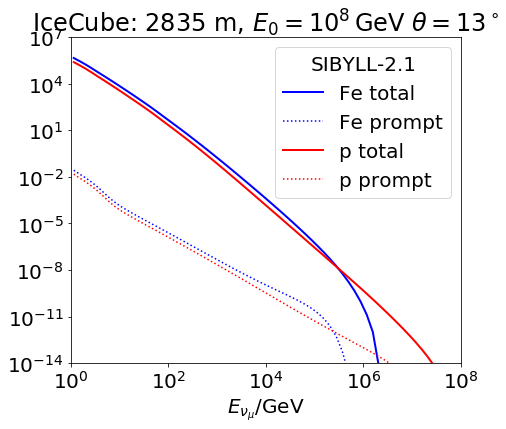

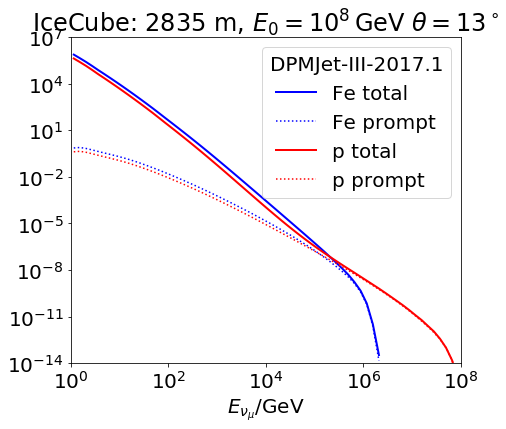

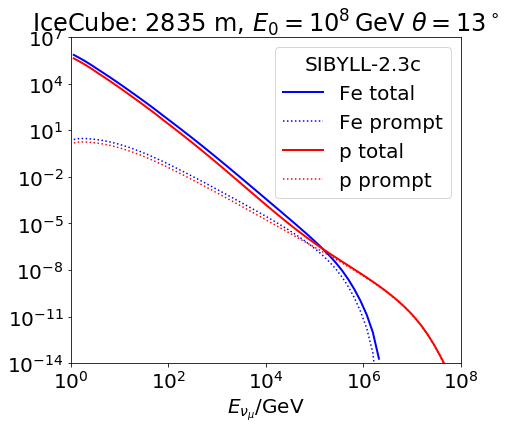

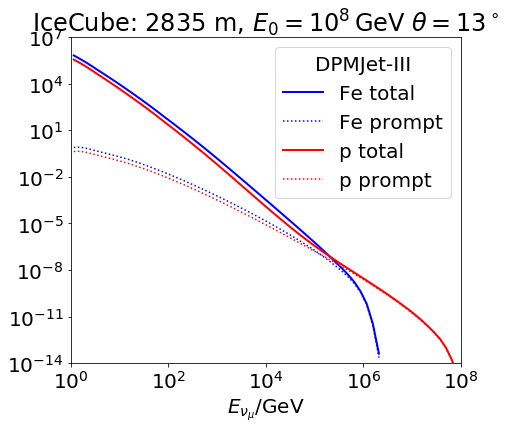

In [11]:
# neutrino spectra
for interaction_model, prim_spectra in lepton_spectra["icecube"].items():
    plt.figure()
    plt.title(r"IceCube: 2835 m, $E_0 = 10^8\,$GeV $\theta = 13^\circ$")
    for prim, spectra in prim_spectra.items():
        x = spectra["egrid"]
        y1 = spectra["numu_total"]
        y2 = spectra["numu_pr"]
        color = {"proton" : "r", "iron": "b"}[prim]
        label = {"proton" : "p", "iron": "Fe"}[prim] 
        plt.plot(x, y1, "k-", color=color, lw=2, label=label + " total")
        plt.plot(x, y2, "k:", color=color, label=label + " prompt")
    plt.loglog()
    plt.xlim(1, 1e8)
    plt.ylim(1e-14, 1e7)
    plt.xlabel(r"$E_{\nu_\mu}$/GeV")
    plt.legend(title=interaction_model)